In [1]:
from sentence_transformers import SentenceTransformer
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import hashlib
from functools import lru_cache

# Load model
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Generate example sentences for benchmarking
sentences = [
    f"This is a sample sentence for benchmarking embeddings generation {i}."
    for i in range(1000)
]

print(f"Created {len(sentences)} example sentences")

Created 1000 example sentences


In [2]:
# 1. Batch Size Impact on Throughput and Latency
import pandas as pd
batch_sizes = [1, 4, 8, 16, 32, 64, 128, 256]
results = []

print("Measuring impact of batch size on throughput and latency...")

for batch_size in tqdm(batch_sizes):
    start_time = time.time()

    # Process data in batches
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        batch_embeddings = model.encode(batch)
        embeddings.extend(batch_embeddings)

    # Calculate metrics
    total_time = time.time() - start_time
    throughput = len(sentences) / total_time
    avg_latency = total_time / (len(sentences) / batch_size)

    results.append({
        'Batch Size': batch_size,
        'Total Time (s)': total_time,
        'Throughput (samples/s)': throughput,
        'Avg Batch Latency (s)': avg_latency
    })

# Convert to DataFrame
df = pd.DataFrame(results)
print(df)

Measuring impact of batch size on throughput and latency...


  0%|          | 0/8 [00:00<?, ?it/s]

   Batch Size  Total Time (s)  Throughput (samples/s)  Avg Batch Latency (s)
0           1       11.840518               84.455761               0.011841
1           4        4.780747              209.172335               0.019123
2           8        3.543526              282.204811               0.028348
3          16        2.993084              334.103559               0.047889
4          32        3.359812              297.635678               0.107514
5          64        2.925729              341.795152               0.187247
6         128        2.781530              359.514380               0.356036
7         256        3.731268              268.005429               0.955205


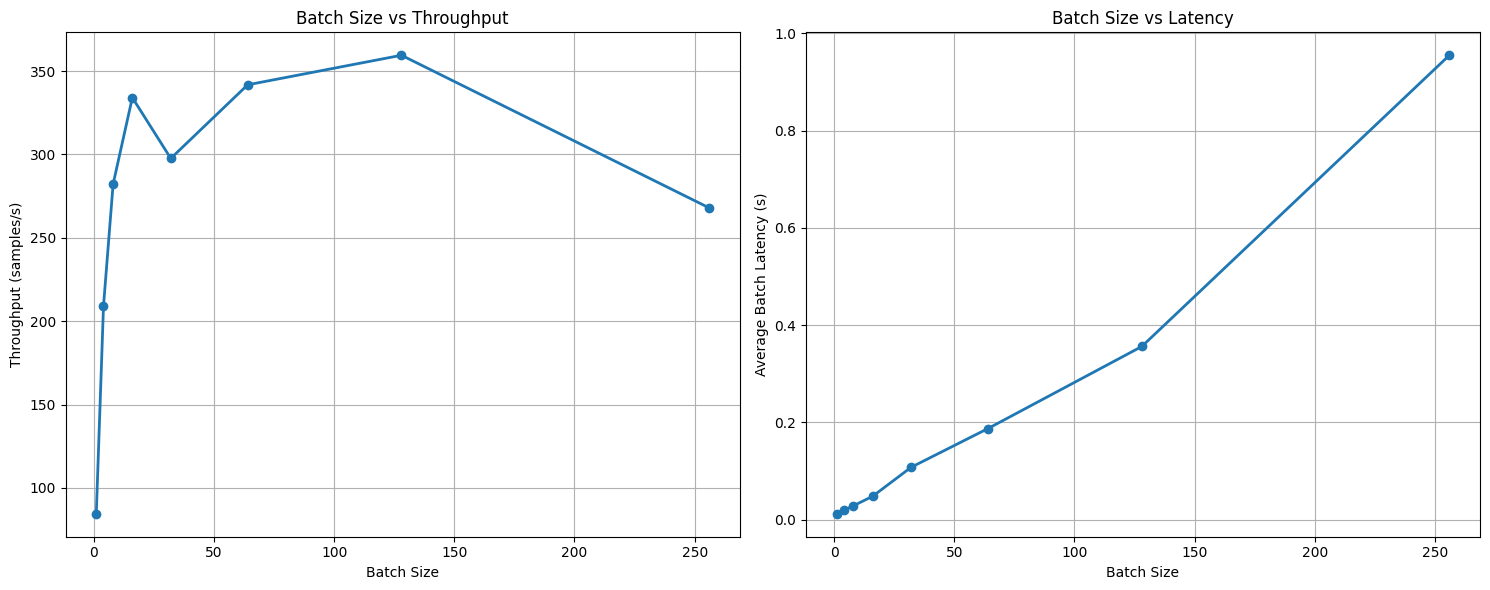

In [3]:
# Visualize the results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(df['Batch Size'], df['Throughput (samples/s)'], 'o-', linewidth=2)
plt.xlabel('Batch Size')
plt.ylabel('Throughput (samples/s)')
plt.title('Batch Size vs Throughput')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df['Batch Size'], df['Avg Batch Latency (s)'], 'o-', linewidth=2)
plt.xlabel('Batch Size')
plt.ylabel('Average Batch Latency (s)')
plt.title('Batch Size vs Latency')
plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# 2. Implementing a Simple Embedding Cache

class SimpleEmbeddingCache:
    def __init__(self, model):
        self.model = model
        self.cache = {}
        self.hits = 0
        self.misses = 0

    def _get_hash(self, text):
        return hashlib.md5(text.encode('utf-8')).hexdigest()

    def encode(self, texts, batch_size=32):
        results = []
        texts_to_encode = []
        text_indices = []

        # Check cache for each text
        for i, text in enumerate(texts):
            text_hash = self._get_hash(text)
            if text_hash in self.cache:
                results.append((i, self.cache[text_hash]))
                self.hits += 1
            else:
                texts_to_encode.append(text)
                text_indices.append(i)
                self.misses += 1

        # Generate embeddings for cache misses
        if texts_to_encode:
            # Process in batches
            new_embeddings = []
            for i in range(0, len(texts_to_encode), batch_size):
                batch = texts_to_encode[i:i+batch_size]
                batch_embeddings = self.model.encode(batch)
                new_embeddings.extend(batch_embeddings)

            # Update cache with new embeddings
            for i, text in enumerate(texts_to_encode):
                text_hash = self._get_hash(text)
                self.cache[text_hash] = new_embeddings[i]
                results.append((text_indices[i], new_embeddings[i]))

        # Sort by original index and extract embeddings
        results.sort(key=lambda x: x[0])
        return np.array([emb for _, emb in results])

    def get_stats(self):
        total = self.hits + self.misses
        hit_rate = self.hits / total if total > 0 else 0
        return {
            "hits": self.hits,
            "misses": self.misses,
            "total": total,
            "hit_rate": hit_rate
        }

In [5]:
# b. Function-based cache using lru_cache
@lru_cache(maxsize=1024)
def hash_text(text):
    return hashlib.md5(text.encode('utf-8')).hexdigest()


class LRUEmbeddingCache:
    def __init__(self, model, maxsize=1024):
        self.model = model
        self.encode_single = lru_cache(maxsize=maxsize)(self._encode_single)
        self.hits = 0
        self.misses = 0

    def _encode_single(self, text_hash):
        self.misses += 1
        # Convert hash back to the original text
        text = self.hash_to_text[text_hash]
        return self.model.encode(text)

    def encode(self, texts, batch_size=32):
        self.hash_to_text = {}
        results = []

        for text in texts:
            # Use the hash as the cache key
            text_hash = hash_text(text)
            self.hash_to_text[text_hash] = text

            # Get from cache if exists
            embedding = self.encode_single(text_hash)
            if embedding is not None:
                results.append(embedding)

        return np.array(results)

    def get_stats(self):
        total = self.hits + self.misses
        hit_rate = self.hits / total if total > 0 else 0
        return {
            "hits": self.hits,
            "misses": self.misses,
            "total": total,
            "hit_rate": hit_rate
        }

In [6]:
# Benchmark caching strategies
print("\nBenchmarking caching strategies...")

# Generate a dataset with some repeated content
repeated_sentences = []
for i in range(500):
    # Add some repetition to demonstrate cache benefits
    if i % 5 == 0:
        repeated_sentences.append(sentences[i % 100])
    else:
        repeated_sentences.append(sentences[i])

# Test without cache
start_time = time.time()
embeddings_no_cache = model.encode(repeated_sentences, batch_size=32)
no_cache_time = time.time() - start_time
print(f"Time without cache: {no_cache_time:.4f}s")

# Test with simple cache
simple_cache = SimpleEmbeddingCache(model)
start_time = time.time()
embeddings_simple_cache = simple_cache.encode(
    repeated_sentences, batch_size=32)
simple_cache_time = time.time() - start_time
print(f"Time with simple cache: {simple_cache_time:.4f}s")
print(f"Simple cache stats: {simple_cache.get_stats()}")


Benchmarking caching strategies...
Time without cache: 1.4563s
Time with simple cache: 1.4093s
Simple cache stats: {'hits': 0, 'misses': 500, 'total': 500, 'hit_rate': 0.0}


## Real-World Applications
Let's discuss how batching and caching apply in real-world scenarios:

- Search applications: When users search for similar content, you can cache embeddings for frequently searched terms.
- Content recommendation systems: Product descriptions, articles, or other items that appear frequently can have their embeddings cached.
- Customer support systems: Common questions or support tickets can benefit from cached embeddings.
- Document processing pipelines: When processing documents, batch them together for maximum throughput.
- API services: Implement caching layers to avoid regenerating embeddings for common requests.

## Production Best Practices
Here are some practical tips for implementing these techniques in production:

- Choose batch size based on your latency requirements: If you need real-time responses, smaller batches may be better.
- Monitor your cache hit rate: A low hit rate might mean your cache strategy needs adjustment.
- Consider cache expiration policies: In some applications, content changes over time and cached embeddings may need refreshing.
- Use persistent caching for production: Consider Redis, Memcached, or database-backed caches for production systems.
- Scale horizontally: For very high throughput needs, consider distributing embedding generation across multiple servers.